# Amadeus v1 - Music Genre Classification

## Import Libraries and Data

In [8]:
import random
import sklearn
import librosa 
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display as dis

In [10]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [18]:
raw_data = np.genfromtxt('database.csv', delimiter=',', dtype=None, encoding='UTF8')

## Load Example Genre

Genres:
* Classical
* Country
* Disco
* Hiphop
* Jazz
* Rock
* Blues
* Reggae
* Pop
* Metal

In [5]:
genre = 'Classical'

mapping = {
    'Classical': 0,
    'Country': 100,
    'Disco': 200,
    'Hiphop': 300,
    'Jazz': 400,
    'Rock': 500,
    'Blues': 600,
    'Reggae': 700,
    'Pop': 800,
    'Metal': 900
}

index = random.randint(mapping[genre], mapping[genre]+99)
print(genre, ":", index)
    
ex = raw_data[index][0]
data, sr = librosa.load(ex, mono=True, duration=30)
ipd.Audio(ex)

Classical : 88


## Extract Mel-Spectrogram from Example

In the previous model, I used a standard neural network after extracting audio signal features for the input. However, for this model, I will be using a CNN with the mel-spectograms of the audio clips.

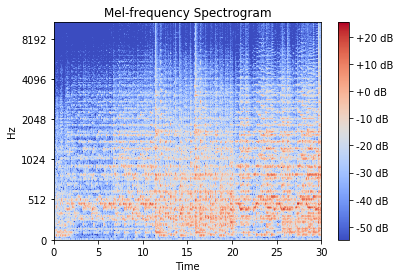

In [9]:
S = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=512)
S_dB = librosa.power_to_db(S)
dis.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency Spectrogram')
plt.show()

## Data Helper Functions

In [34]:
def split_dataset(dataset):
    permutation = np.random.permutation(dataset.shape[0])
    split = int(dataset.shape[0]*0.85)
    X_train = dataset[permutation[:split], :-1]
    Y_train = dataset[permutation[:split], -1:]
    X_test = dataset[permutation[split:], :-1]
    Y_test = dataset[permutation[split:], -1:]
    return X_train, Y_train, X_test, Y_test

In [84]:
def create_melspectrograms(X, n):
    print('Converting to melspectrograms. This might take a while.')
    X_new = np.empty([X.shape[0], n, 1290])
    for i in range(X.shape[0]):
        ex = X[i][0]
        data, sr = librosa.load(ex, mono=True, duration=30)
        data = data[:660000]
        S = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=n)
        S_dB = librosa.power_to_db(S)
        X_new[i] = S_dB
        if i % 100 == 99:
            print('Finished another 100 points of music feature extraction.')
    return X_new

In [74]:
def convert_labels(Y):
    Y_new = np.zeros([Y.shape[0], 1], dtype=int)
    encoding = {
        'classical': 0,
        'country': 1,
        'disco': 2,
        'hiphop': 3,
        'jazz': 4,
        'rock': 5,
        'blues': 6,
        'reggae': 7,
        'pop': 8,
        'metal': 9
    }
    for i in range(Y.shape[0]):
        Y_new[i] = encoding[Y[i][0]]
    return Y_new

In [75]:
def one_hot_encoding(Y, total):
    encoded = np.eye(total)[Y.reshape(-1)]
    return encoded

In [90]:
X_train_raw, Y_train_raw, X_test_raw, Y_test_raw = split_dataset(raw_data)
X_train = create_melspectrograms(X_train_raw, 256)[..., np.newaxis]
Y_train = one_hot_encoding(convert_labels(Y_train_raw), 10)
X_test = create_melspectrograms(X_test_raw, 256)[..., np.newaxis]
Y_test = one_hot_encoding(convert_labels(Y_test_raw), 10)

Converting to melspectrograms. This might take a while.
Finished another 100 points of music feature extraction.
Finished another 100 points of music feature extraction.
Finished another 100 points of music feature extraction.
Finished another 100 points of music feature extraction.
Finished another 100 points of music feature extraction.
Finished another 100 points of music feature extraction.
Finished another 100 points of music feature extraction.
Finished another 100 points of music feature extraction.
Converting to melspectrograms. This might take a while.
Finished another 100 points of music feature extraction.


## Create Mel-Spectrogram Sequence Object

In [117]:
class MSpecSequence(Sequence):
    def __init__(self, X, Y, batch_size=32, is_test=False):
        self.X = X
        self.Y = Y
        self.batch_size = batch_size
        self.is_test = is_test
        
    def __len__(self):
        return len(self.X)//self.batch_size

    def __getitem__(self, i):
        return self.X[i*self.batch_size:(i+1)*self.batch_size], self.Y[i*self.batch_size:(i+1)*self.batch_size]

## Create Keras CNN Model

In [109]:
def create_model(shape, num_outputs):
    initial = Input(shape=shape)
    
    X = Conv2D(16, (3, 3), strides=(1, 1), padding='same')(initial)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)
    X = Dropout(0.15)(X)
    
    X = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)
    X = Dropout(0.15)(X)
    
    X = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)
    X = Dropout(0.15)(X)
    
    X = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)
    X = Dropout(0.15)(X)
    
    X = Flatten()(X)
    X = Dropout(0.25)(X)
    X = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(X)
    X = Dropout(0.25)(X)
    predictions = Dense(num_outputs, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.02))(X)
    
    model = Model(inputs=initial, outputs=predictions)
    return model

In [110]:
model = create_model(X_train[0].shape, 10)

In [111]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 256, 1290, 1)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 256, 1290, 16)     160       
_________________________________________________________________
activation_9 (Activation)    (None, 256, 1290, 16)     0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 645, 16)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 128, 645, 16)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 128, 645, 32)      4640      
_________________________________________________________________
activation_10 (Activation)   (None, 128, 645, 32)      0         
__________

In [112]:
model.compile(loss=tf.keras.losses.categorical_crossentropy, 
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=['accuracy'])

In [118]:
batch_size = 32
train_sequence = MSpecSequence(X_train, Y_train)
steps_per_epoch = len(X_train)//batch_size

validation_sequence = MSpecSequence(X_test, Y_test)
validation_steps = len(X_test)//batch_size

In [ ]:
hist = model.fit_generator(train_sequence,
                           steps_per_epoch=steps_per_epoch,
                           validation_data=validation_sequence,
                           validation_steps=validation_steps,
                           epochs=150,
                           verbose=1)

Epoch 1/150
 3/26 [==>...........................] - ETA: 3:42 - loss: 33.0092 - acc: 0.1146

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))